In [12]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from nets import *
from cfgs import *
from data import *
from trainer import *
from payment_utils import get_payment


In [13]:
%matplotlib inline
save_plot = False
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
D = 201

# v1, v2を[0, 1]の範囲で生成
x = np.linspace(0, 1.0, D)

# v3を複数の値でサンプリング（3次元可視化のため）
c = 10
v3_values = np.linspace(0, c, 5)  # v3を0, c/4, c/2, 3c/4, cの5つの値でサンプリング
print(f'v3_values: {v3_values}')

cfg = additive_1x3_constrained_config.cfg
cfg.test.batch_size = D
cfg.test.save_output = True


v3_values: [ 0.   2.5  5.   7.5 10. ]


In [14]:
Net = constrained_additive_net.Net
Generator = constrained_3item_generator.Generator
Trainer = constrained_trainer.Trainer


In [15]:
# 各v3値に対してテストデータを生成し、推論を実行
net = Net(cfg, "test")
m = Trainer(cfg, "test", net)

# 各v3値での結果を保存
alloc_dict = {}
pay_dict = {}

for v3_val in v3_values:
    # 3財のテストデータを生成: [v1, v2, v3]
    X_tst = np.stack([v.flatten() for v in np.meshgrid(x, x)], axis=-1)
    # v3を固定値で追加
    X_tst = np.concatenate([X_tst, np.full((X_tst.shape[0], 1), v3_val)], axis=-1)
    
    # 推論を実行
    generator = Generator(cfg, 'test', X_tst)
    cfg.test.num_batches = int(X_tst.shape[0]/cfg.test.batch_size)
    m.test(generator)
    
    # 結果を読み込み
    alloc = np.load(os.path.join(cfg.dir_name, "alloc_tst_" + str(cfg.test.restore_iter) + ".npy")).reshape(D, D, 3)
    pay = np.load(os.path.join(cfg.dir_name, "pay_tst_" + str(cfg.test.restore_iter) + ".npy")).reshape(D, D)
    
    alloc_dict[v3_val] = alloc
    pay_dict[v3_val] = pay
    print(f"Completed v3 = {v3_val:.2f}")


2025-11-12 21:08:03,242:INFO:TEST ALL-200000: t = 0.2189, Net_Loss: -0.330705, Revenue: 0.330705, Constraint_Viol: 0.000000, Const_Penalty: 0.000000, Const_Lag_Loss: 0.000000, w_constraint: 8.819627
2025-11-12 21:08:03,242:INFO:TEST ALL-200000: t = 0.2189, Net_Loss: -0.330705, Revenue: 0.330705, Constraint_Viol: 0.000000, Const_Penalty: 0.000000, Const_Lag_Loss: 0.000000, w_constraint: 8.819627


Completed v3 = 0.00


2025-11-12 21:08:03,478:INFO:TEST ALL-200000: t = 0.2309, Net_Loss: -0.398795, Revenue: 0.398795, Constraint_Viol: 0.000000, Const_Penalty: 0.000000, Const_Lag_Loss: 0.000000, w_constraint: 8.819627
2025-11-12 21:08:03,478:INFO:TEST ALL-200000: t = 0.2309, Net_Loss: -0.398795, Revenue: 0.398795, Constraint_Viol: 0.000000, Const_Penalty: 0.000000, Const_Lag_Loss: 0.000000, w_constraint: 8.819627
2025-11-12 21:08:03,671:INFO:TEST ALL-200000: t = 0.1890, Net_Loss: -4.850310, Revenue: 4.850310, Constraint_Viol: 0.000000, Const_Penalty: 0.000000, Const_Lag_Loss: 0.000000, w_constraint: 8.819627
2025-11-12 21:08:03,671:INFO:TEST ALL-200000: t = 0.1890, Net_Loss: -4.850310, Revenue: 4.850310, Constraint_Viol: 0.000000, Const_Penalty: 0.000000, Const_Lag_Loss: 0.000000, w_constraint: 8.819627


Completed v3 = 2.50
Completed v3 = 5.00


2025-11-12 21:08:03,889:INFO:TEST ALL-200000: t = 0.2138, Net_Loss: -5.450917, Revenue: 5.450917, Constraint_Viol: 0.000000, Const_Penalty: 0.000000, Const_Lag_Loss: 0.000000, w_constraint: 8.819627
2025-11-12 21:08:03,889:INFO:TEST ALL-200000: t = 0.2138, Net_Loss: -5.450917, Revenue: 5.450917, Constraint_Viol: 0.000000, Const_Penalty: 0.000000, Const_Lag_Loss: 0.000000, w_constraint: 8.819627


Completed v3 = 7.50


2025-11-12 21:08:04,117:INFO:TEST ALL-200000: t = 0.2245, Net_Loss: -5.450917, Revenue: 5.450917, Constraint_Viol: 0.000000, Const_Penalty: 0.000000, Const_Lag_Loss: 0.000000, w_constraint: 8.819627
2025-11-12 21:08:04,117:INFO:TEST ALL-200000: t = 0.2245, Net_Loss: -5.450917, Revenue: 5.450917, Constraint_Viol: 0.000000, Const_Penalty: 0.000000, Const_Lag_Loss: 0.000000, w_constraint: 8.819627


Completed v3 = 10.00


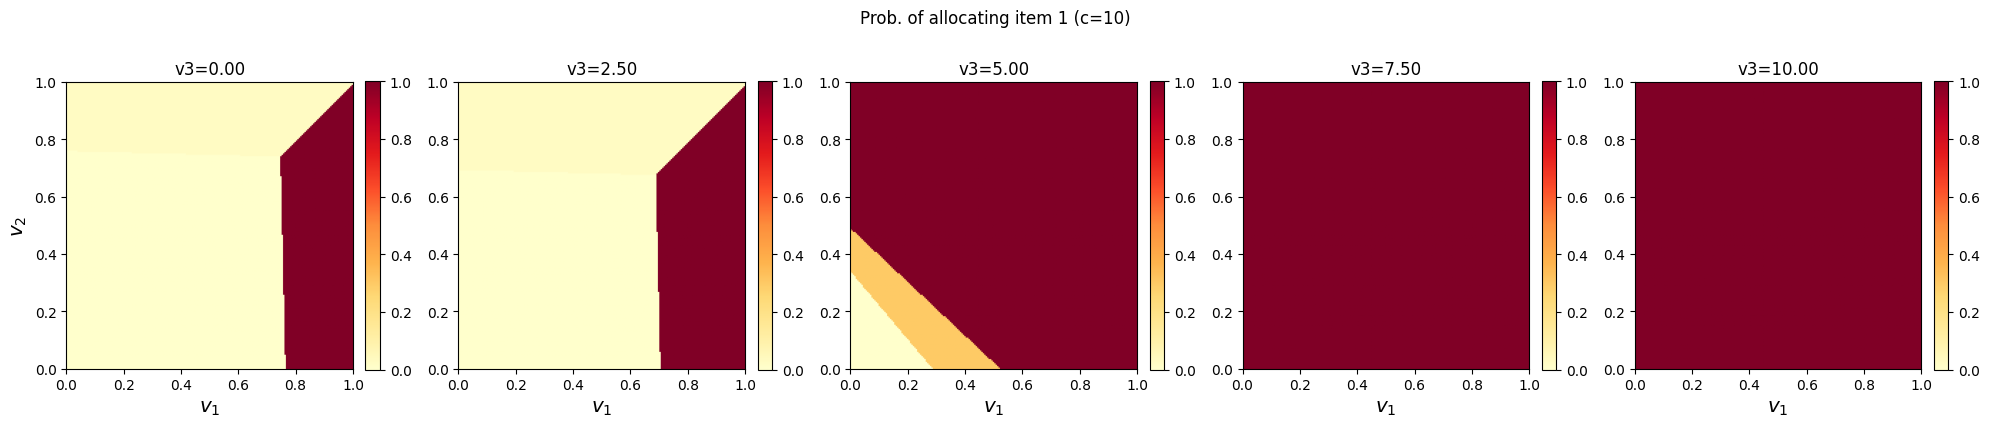

In [16]:
# 財1の配分確率を複数のv3値で可視化
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
fig, axes = plt.subplots(ncols=len(v3_values), nrows=1, figsize=(4*len(v3_values), 4))

for idx, v3_val in enumerate(v3_values):
    alloc = alloc_dict[v3_val]
    ax = axes[idx]
    img = ax.imshow(alloc[::-1, :, 0], extent=[0, 1, 0, 1], vmin=0.0, vmax=1.0, cmap='YlOrRd')
    ax.set_xlabel(r'$v_1$')
    if idx == 0:
        ax.set_ylabel(r'$v_2$')
    ax.set_title(f'v3={v3_val:.2f}')
    plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle(f'Prob. of allocating item 1 (c={c})', y=1.02)
plt.tight_layout()

if save_plot:
    plt.savefig(os.path.join(cfg.dir_name, 'alloc1_3d.pdf'), bbox_inches='tight', pad_inches=0.05)


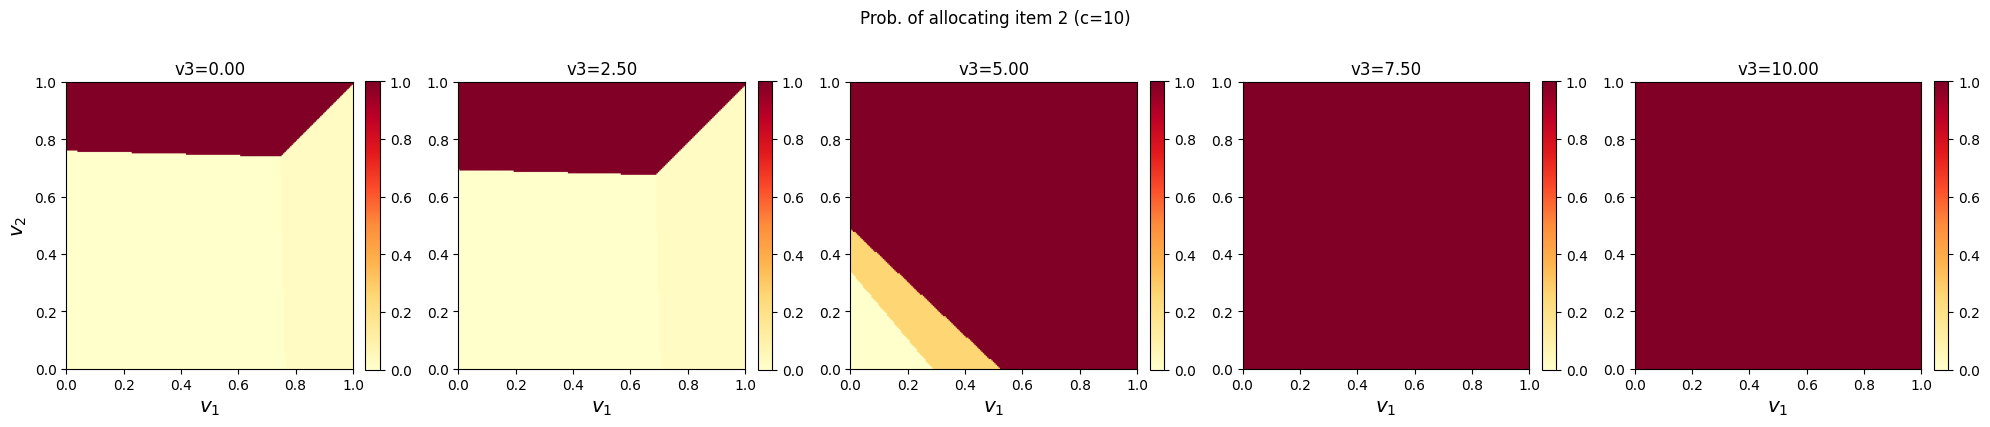

In [18]:
# 財2の配分確率を複数のv3値で可視化
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
fig, axes = plt.subplots(ncols=len(v3_values), nrows=1, figsize=(4*len(v3_values), 4))

for idx, v3_val in enumerate(v3_values):
    alloc = alloc_dict[v3_val]
    ax = axes[idx]
    img = ax.imshow(alloc[::-1, :, 1], extent=[0, 1, 0, 1], vmin=0.0, vmax=1.0, cmap='YlOrRd')
    ax.set_xlabel(r'$v_1$')
    if idx == 0:
        ax.set_ylabel(r'$v_2$')
    ax.set_title(f'v3={v3_val:.2f}')
    plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle(f'Prob. of allocating item 2 (c={c})', y=1.02)
plt.tight_layout()

if save_plot:
    plt.savefig(os.path.join(cfg.dir_name, 'alloc2_3d.pdf'), bbox_inches='tight', pad_inches=0.05)


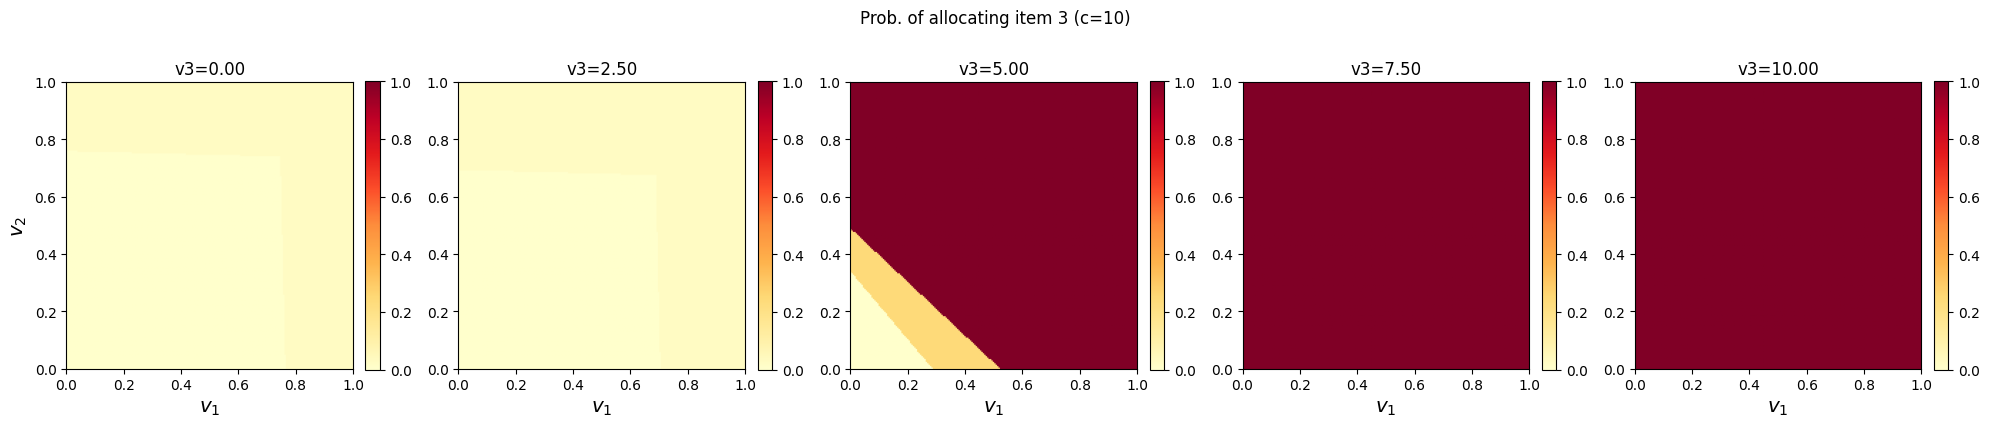

In [19]:
# 財3の配分確率を複数のv3値で可視化
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
fig, axes = plt.subplots(ncols=len(v3_values), nrows=1, figsize=(4*len(v3_values), 4))

for idx, v3_val in enumerate(v3_values):
    alloc = alloc_dict[v3_val]
    ax = axes[idx]
    img = ax.imshow(alloc[::-1, :, 2], extent=[0, 1, 0, 1], vmin=0.0, vmax=1.0, cmap='YlOrRd')
    ax.set_xlabel(r'$v_1$')
    if idx == 0:
        ax.set_ylabel(r'$v_2$')
    ax.set_title(f'v3={v3_val:.2f}')
    plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle(f'Prob. of allocating item 3 (c={c})', y=1.02)
plt.tight_layout()

if save_plot:
    plt.savefig(os.path.join(cfg.dir_name, 'alloc3_3d.pdf'), bbox_inches='tight', pad_inches=0.05)


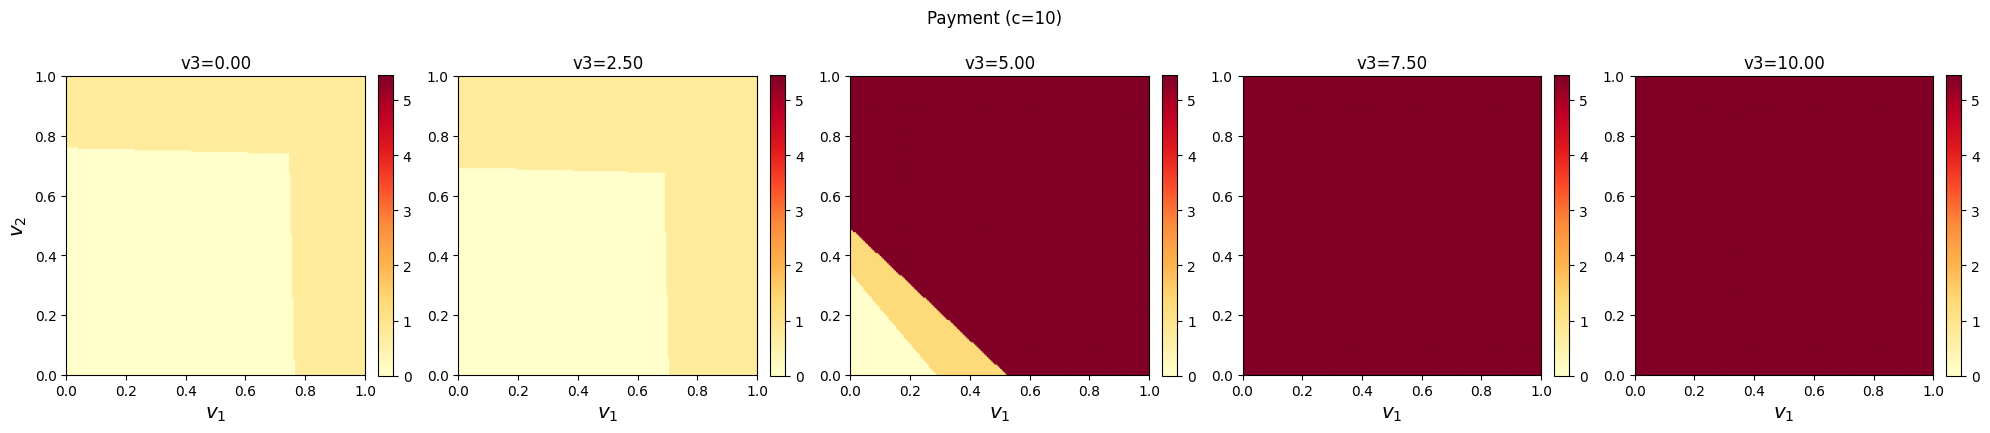

In [20]:
# Paymentを複数のv3値で可視化
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})

# すべてのv3値でのpaymentの最大値と最小値を計算（色スケール統一のため）
pay_min = min([np.min(pay_dict[v3_val]) for v3_val in v3_values])
pay_max = max([np.max(pay_dict[v3_val]) for v3_val in v3_values])

fig, axes = plt.subplots(ncols=len(v3_values), nrows=1, figsize=(4*len(v3_values), 4))

for idx, v3_val in enumerate(v3_values):
    pay = pay_dict[v3_val]
    ax = axes[idx]
    img = ax.imshow(pay[::-1, :], extent=[0, 1, 0, 1], cmap='YlOrRd', vmin=pay_min, vmax=pay_max)
    ax.set_xlabel(r'$v_1$')
    if idx == 0:
        ax.set_ylabel(r'$v_2$')
    ax.set_title(f'v3={v3_val:.2f}')
    plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle(f'Payment (c={c})', y=1.02)
plt.tight_layout()

if save_plot:
    plt.savefig(os.path.join(cfg.dir_name, 'pay_3d.pdf'), bbox_inches='tight', pad_inches=0.05)


In [21]:
# 制約違反の確認（各v3値に対して）
print("Constraint Violation Statistics for each v3:")
for v3_val in v3_values:
    alloc = alloc_dict[v3_val]
    # 下界: max(0, alloc1 + alloc2 - 1) <= alloc3
    # 上界: alloc3 <= min(alloc1, alloc2)
    lower_bound = np.maximum(0, alloc[:, :, 0] + alloc[:, :, 1] - 1)
    upper_bound = np.minimum(alloc[:, :, 0], alloc[:, :, 1])
    lower_violation = np.maximum(0, lower_bound - alloc[:, :, 2])
    upper_violation = np.maximum(0, alloc[:, :, 2] - upper_bound)
    constraint_violation = lower_violation + upper_violation
    
    print(f"\nv3 = {v3_val:.2f}:")
    print(f"  Min: {np.min(constraint_violation):.6f}")
    print(f"  Max: {np.max(constraint_violation):.6f}")
    print(f"  Mean: {np.mean(constraint_violation):.6f}")
    print(f"  Number of violations: {np.sum(constraint_violation > 1e-6)}")


Constraint Violation Statistics for each v3:

v3 = 0.00:
  Min: 0.000000
  Max: 0.000000
  Mean: 0.000000
  Number of violations: 0

v3 = 2.50:
  Min: 0.000000
  Max: 0.000000
  Mean: 0.000000
  Number of violations: 0

v3 = 5.00:
  Min: 0.000000
  Max: 0.000000
  Mean: 0.000000
  Number of violations: 0

v3 = 7.50:
  Min: 0.000000
  Max: 0.000000
  Mean: 0.000000
  Number of violations: 0

v3 = 10.00:
  Min: 0.000000
  Max: 0.000000
  Mean: 0.000000
  Number of violations: 0


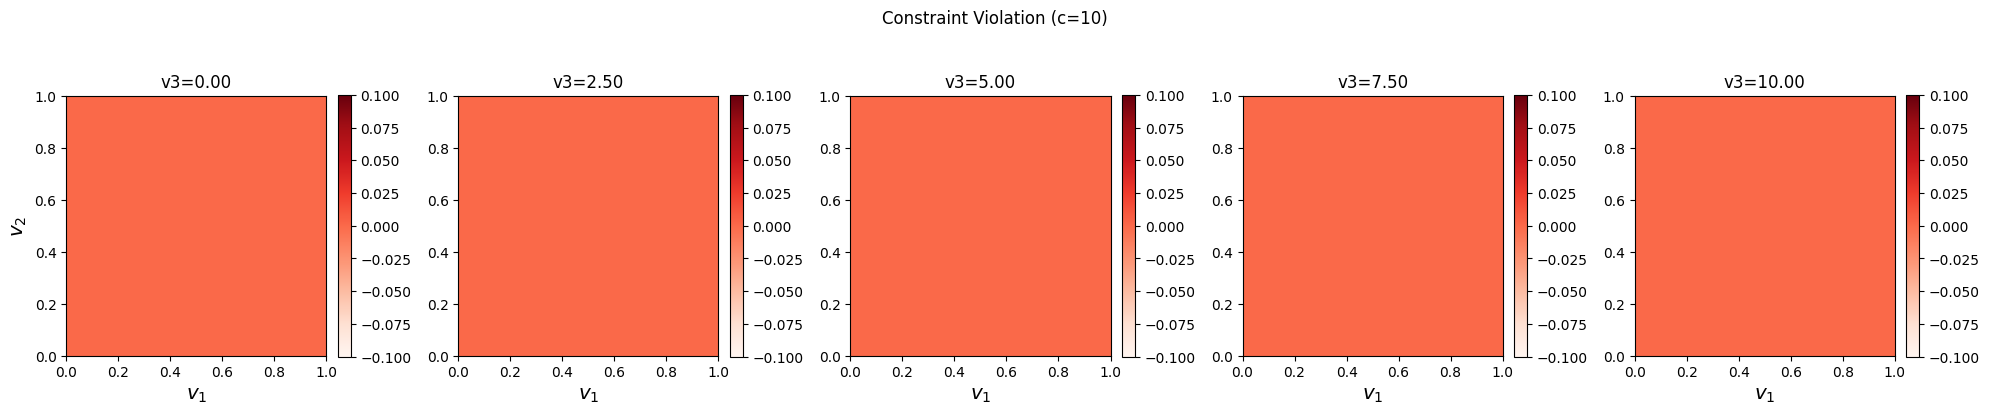

In [22]:
# 制約違反を複数のv3値で可視化
plt.rcParams.update({'font.size': 10, 'axes.labelsize': 'x-large'})
fig, axes = plt.subplots(ncols=len(v3_values), nrows=1, figsize=(4*len(v3_values), 4))

for idx, v3_val in enumerate(v3_values):
    alloc = alloc_dict[v3_val]
    lower_bound = np.maximum(0, alloc[:, :, 0] + alloc[:, :, 1] - 1)
    upper_bound = np.minimum(alloc[:, :, 0], alloc[:, :, 1])
    lower_violation = np.maximum(0, lower_bound - alloc[:, :, 2])
    upper_violation = np.maximum(0, alloc[:, :, 2] - upper_bound)
    constraint_violation = lower_violation + upper_violation
    
    ax = axes[idx]
    img = ax.imshow(constraint_violation[::-1, :], extent=[0, 1, 0, 1], cmap='Reds')
    ax.set_xlabel(r'$v_1$')
    if idx == 0:
        ax.set_ylabel(r'$v_2$')
    ax.set_title(f'v3={v3_val:.2f}')
    plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04)

plt.suptitle(f'Constraint Violation (c={c})', y=1.02)
plt.tight_layout()

if save_plot:
    plt.savefig(os.path.join(cfg.dir_name, 'constraint_violation_3d.pdf'), bbox_inches='tight', pad_inches=0.05)


In [23]:
# Payment statistics（各v3値に対して）
v_max = x[-1]
print("Payment Statistics for each v3:")
for v3_val in v3_values:
    pay = pay_dict[v3_val]
    print(f"\nv3 = {v3_val:.2f}:")
    print(f"  Min: {np.min(pay):.6f}")
    print(f"  Max: {np.max(pay):.6f}")
    print(f"  Mean: {np.mean(pay):.6f}")
    print(f"  Median: {np.median(pay):.6f}")
    print(f"  Std: {np.std(pay):.6f}")
    print(f"  Payment at selected points:")
    print(f"    pay[0, 0] (v1=0, v2=0): {pay[0, 0]:.6f}")
    print(f"    pay[D//2, D//2] (v1={v_max/2:.1f}, v2={v_max/2:.1f}): {pay[D//2, D//2]:.6f}")
    print(f"    pay[-1, -1] (v1={v_max:.1f}, v2={v_max:.1f}): {pay[-1, -1]:.6f}")


Payment Statistics for each v3:

v3 = 0.00:
  Min: 0.000000
  Max: 0.766087
  Mean: 0.330705
  Median: 0.000000
  Std: 0.378315
  Payment at selected points:
    pay[0, 0] (v1=0, v2=0): 0.000000
    pay[D//2, D//2] (v1=0.5, v2=0.5): 0.000000
    pay[-1, -1] (v1=1.0, v2=1.0): 0.760962

v3 = 2.50:
  Min: 0.000000
  Max: 0.766087
  Mean: 0.398795
  Median: 0.760962
  Std: 0.381345
  Payment at selected points:
    pay[0, 0] (v1=0, v2=0): 0.000000
    pay[D//2, D//2] (v1=0.5, v2=0.5): 0.000000
    pay[-1, -1] (v1=1.0, v2=1.0): 0.760962

v3 = 5.00:
  Min: 0.000000
  Max: 5.450917
  Mean: 4.850309
  Median: 5.450917
  Std: 1.576445
  Payment at selected points:
    pay[0, 0] (v1=0, v2=0): 0.000000
    pay[D//2, D//2] (v1=0.5, v2=0.5): 5.450917
    pay[-1, -1] (v1=1.0, v2=1.0): 5.450917

v3 = 7.50:
  Min: 5.450917
  Max: 5.450917
  Mean: 5.450917
  Median: 5.450917
  Std: 0.000000
  Payment at selected points:
    pay[0, 0] (v1=0, v2=0): 5.450917
    pay[D//2, D//2] (v1=0.5, v2=0.5): 5.450917